# Step 1: Import Required Libraries

In [2]:
# Import necessary libraries for model training, data preprocessing, and evaluation
import os
import shutil
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from google.colab import files



# Step 2: Define Data Preparation Functions

In [3]:
uploaded = files.upload()

Saving Soil types.zip to Soil types.zip


In [4]:
with zipfile.ZipFile("Soil types.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# List the extracted files to verify
print(os.listdir("dataset"))

['Soil types']


In [5]:
# Function to split dataset into train, validation, and test sets
def create_train_val_test_splits(source_dir, train_dir, val_dir, test_dir, val_split=0.2, test_split=0.1, random_state=42):
    # Create directories for train, validation, and test splits
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Define class names for the dataset
    classes = ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Yellow Soil']

    for class_name in classes:
        # Create class-specific directories
        train_class_dir = os.path.join(train_dir, class_name.replace(' ', '_'))
        val_class_dir = os.path.join(val_dir, class_name.replace(' ', '_'))
        test_class_dir = os.path.join(test_dir, class_name.replace(' ', '_'))
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get all images for this class
        class_dir = os.path.join(source_dir, class_name.replace(' ', '_'))
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found")
            continue

        images = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        if not images:
            print(f"Warning: No images found in {class_dir}")
            continue

        # Split into train, test, and validation
        train_images, test_images = train_test_split(images, test_size=test_split, random_state=random_state, shuffle=True)
        train_images, val_images = train_test_split(train_images, test_size=val_split, random_state=random_state, shuffle=True)

        # Copy images to respective directories
        for img in train_images:
            shutil.copy2(os.path.join(class_dir, img), os.path.join(train_class_dir, img))

        for img in val_images:
            shutil.copy2(os.path.join(class_dir, img), os.path.join(val_class_dir, img))

        for img in test_images:
            shutil.copy2(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

        print(f"{class_name}:")
        print(f"  Total images: {len(images)}")
        print(f"  Training images: {len(train_images)}")
        print(f"  Validation images: {len(val_images)}")
        print(f"  Testing images: {len(test_images)}")

# Function to display dataset statistics
def display_dataset_stats(data_dir):
    classes = os.listdir(data_dir)
    print(f"\nDataset statistics for {data_dir}:")
    total_images = 0

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len([f for f in os.listdir(class_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
            print(f"{class_name}: {num_images} images")
            total_images += num_images

    print(f"Total images: {total_images}")


# Step 3: Prepare Data Splits

In [6]:
# Define dataset directories
source_directory = "dataset/Soil types"
train_directory = "data/train"
val_directory = "data/val"
test_directory = "data/test"

# Split data into train, validation, and test sets
create_train_val_test_splits(
    source_dir=source_directory,
    train_dir=train_directory,
    val_dir=val_directory,
    test_dir=test_directory,
    val_split=0.2,
    test_split=0.1
)

# Display dataset statistics for each split
print("\nTraining Dataset:")
display_dataset_stats(train_directory)
print("\nValidation Dataset:")
display_dataset_stats(val_directory)
print("\nTesting Dataset:")
display_dataset_stats(test_directory)


Black Soil:
  Total images: 37
  Training images: 26
  Validation images: 7
  Testing images: 4
Cinder Soil:
  Total images: 30
  Training images: 21
  Validation images: 6
  Testing images: 3
Laterite Soil:
  Total images: 30
  Training images: 21
  Validation images: 6
  Testing images: 3
Yellow Soil:
  Total images: 29
  Training images: 20
  Validation images: 6
  Testing images: 3

Training Dataset:

Dataset statistics for data/train:
Cinder_Soil: 21 images
Black_Soil: 26 images
Laterite_Soil: 21 images
Yellow_Soil: 20 images
Total images: 88

Validation Dataset:

Dataset statistics for data/val:
Cinder_Soil: 6 images
Black_Soil: 7 images
Laterite_Soil: 6 images
Yellow_Soil: 6 images
Total images: 25

Testing Dataset:

Dataset statistics for data/test:
Cinder_Soil: 3 images
Black_Soil: 4 images
Laterite_Soil: 3 images
Yellow_Soil: 3 images
Total images: 13


# Step 4: Define Data Loaders


In [7]:
# Define transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_data = ImageFolder(train_directory, transform=train_transform)
val_data = ImageFolder(val_directory, transform=val_transform)
test_data = ImageFolder(test_directory, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


# Step 5: Define Models

In [8]:
# Baseline Model using ResNet50
class BaselineModel(nn.Module):
    def __init__(self, num_classes=4):
        super(BaselineModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Enhanced Model with additional layers
class EnhancedModel(nn.Module):
    def __init__(self, num_classes=4):
        super(EnhancedModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


# Step 6: Train and Evaluate Models

In [9]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return history



In [11]:
# Evaluation function
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return classification_report(all_labels, all_preds), confusion_matrix(all_labels, all_preds)

In [21]:
# Train the Baseline Model
baseline_model = BaselineModel(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

baseline_history = train_model(
    baseline_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10
)
baseline_report, baseline_cm = evaluate_model(baseline_model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 1.5212, Train Acc: 22.73%
Val Loss: 1.2754, Val Acc: 48.00%
Epoch 2/10:
Train Loss: 1.2419, Train Acc: 53.41%
Val Loss: 1.2616, Val Acc: 48.00%
Epoch 3/10:
Train Loss: 1.1501, Train Acc: 54.55%
Val Loss: 1.0243, Val Acc: 84.00%
Epoch 4/10:
Train Loss: 0.9588, Train Acc: 78.41%
Val Loss: 0.8678, Val Acc: 80.00%
Epoch 5/10:
Train Loss: 0.8492, Train Acc: 72.73%
Val Loss: 0.7637, Val Acc: 88.00%
Epoch 6/10:
Train Loss: 0.7020, Train Acc: 85.23%
Val Loss: 0.6979, Val Acc: 88.00%
Epoch 7/10:
Train Loss: 0.6940, Train Acc: 82.95%
Val Loss: 0.6592, Val Acc: 88.00%
Epoch 8/10:
Train Loss: 0.6601, Train Acc: 86.36%
Val Loss: 0.5758, Val Acc: 92.00%
Epoch 9/10:
Train Loss: 0.5088, Train Acc: 92.05%
Val Loss: 0.5036, Val Acc: 88.00%
Epoch 10/10:
Train Loss: 0.4808, Train Acc: 94.32%
Val Loss: 0.4922, Val Acc: 88.00%


In [22]:
# Train the Enhanced Model
enhanced_model = EnhancedModel(num_classes=4)
optimizer = torch.optim.Adam(enhanced_model.parameters(), lr=0.001)


enhanced_history = train_model(
    enhanced_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10
)
enhanced_report, enhanced_cm = evaluate_model(enhanced_model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
Train Loss: 1.2385, Train Acc: 43.18%
Val Loss: 1.1410, Val Acc: 40.00%
Epoch 2/10:
Train Loss: 0.4711, Train Acc: 88.64%
Val Loss: 0.6518, Val Acc: 76.00%
Epoch 3/10:
Train Loss: 0.2878, Train Acc: 97.73%
Val Loss: 0.2562, Val Acc: 96.00%
Epoch 4/10:
Train Loss: 0.1666, Train Acc: 96.59%
Val Loss: 0.1364, Val Acc: 96.00%
Epoch 5/10:
Train Loss: 0.2142, Train Acc: 94.32%
Val Loss: 0.1135, Val Acc: 96.00%
Epoch 6/10:
Train Loss: 0.0895, Train Acc: 98.86%
Val Loss: 0.5222, Val Acc: 88.00%
Epoch 7/10:
Train Loss: 0.1316, Train Acc: 95.45%
Val Loss: 0.2197, Val Acc: 96.00%
Epoch 8/10:
Train Loss: 0.1099, Train Acc: 98.86%
Val Loss: 0.1547, Val Acc: 96.00%
Epoch 9/10:
Train Loss: 0.0601, Train Acc: 97.73%
Val Loss: 0.2498, Val Acc: 96.00%
Epoch 10/10:
Train Loss: 0.0509, Train Acc: 100.00%
Val Loss: 0.2968, Val Acc: 92.00%


# Step 7: Visualize Training History

In [23]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

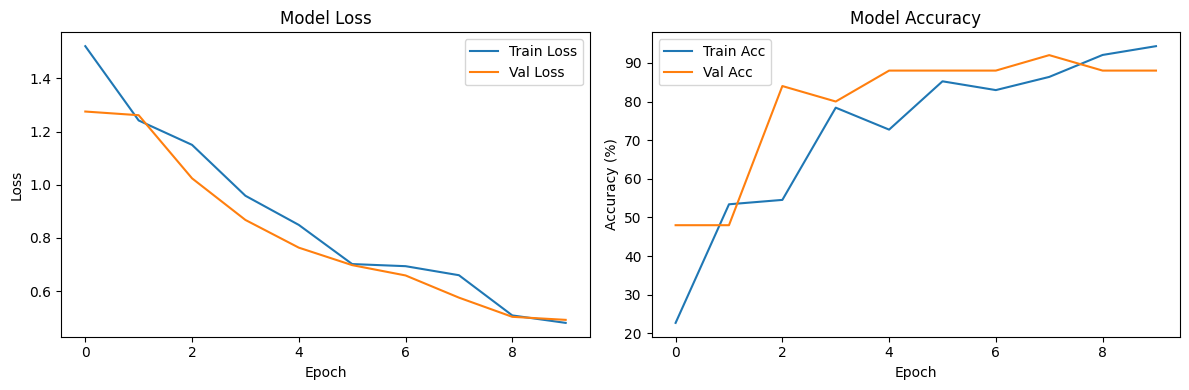

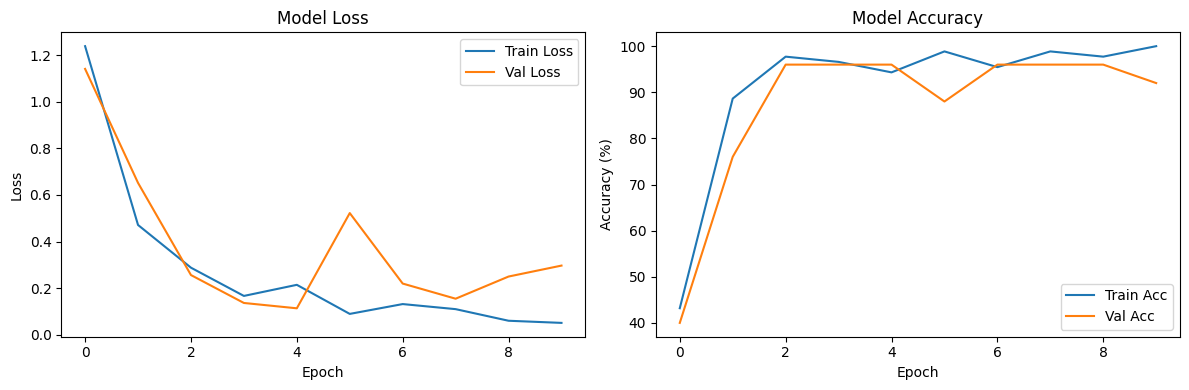

In [24]:

# Plot training history for both models
plot_training_history(baseline_history)
plot_training_history(enhanced_history)

# Step 8: Test the Enhanced Model and Generate Predictions


Classification Report for Enhanced Model:
               precision    recall  f1-score   support

   Black_Soil       1.00      1.00      1.00         4
  Cinder_Soil       1.00      0.67      0.80         3
Laterite_Soil       0.75      1.00      0.86         3
  Yellow_Soil       1.00      1.00      1.00         3

     accuracy                           0.92        13
    macro avg       0.94      0.92      0.91        13
 weighted avg       0.94      0.92      0.92        13



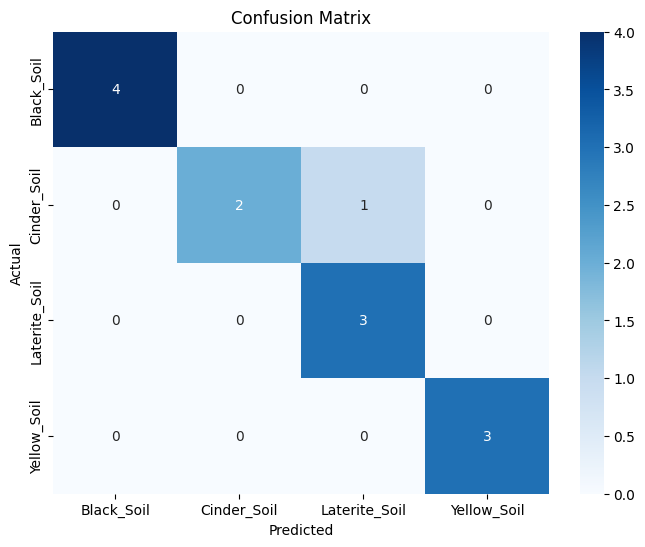

Predicted Class for data/test/Cinder_Soil/13.jpg: Cinder_Soil


In [25]:
# Evaluate the Enhanced Model on the Test Dataset
def test_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Perform testing on the Enhanced Model
all_labels, all_preds = test_model(enhanced_model, test_loader)

# Classification Report
print("\nClassification Report for Enhanced Model:")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))

# Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Plot the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, test_data.classes)

# Example: Making Predictions on Individual Images
def predict_image(image_path, model, transform, device='cuda'):
    from PIL import Image
    model = model.to(device)
    model.eval()

    # Load the image and apply transforms
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    class_idx = predicted_class.item()
    return test_data.classes[class_idx]

# Test prediction on a single image
image_path = "data/test/Cinder_Soil/13.jpg"  # Example test image path
predicted_class = predict_image(image_path, enhanced_model, val_transform)
print(f"Predicted Class for {image_path}: {predicted_class}")


In [19]:
# Save the enhanced model
torch.save(enhanced_model.state_dict(), "enhanced_model.pth")
print("Enhanced model saved as 'enhanced_model.pth'.")


Enhanced model saved as 'enhanced_model.pth'.


In [20]:


# Download the saved model file
files.download("enhanced_model1.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>